I want to use the unified radio catalog created by Kimball & Ivezic to basically get all radio-detected sources in one place, and then match with WISE -- which should match to a high fraction of those sources.

THIS IS THE FULL CATALOG VERSION - SEE ``kimball_catalog_small.ipynb`` FOR A BASIC IDEA OF THIS METHOD USING A SMALL REGION OF THE SKY

In [67]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from astropy.table import Table

In [68]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
def radluminosity(nu1, nu2, S, alpha, z):
    #calculate luminosity at nu1 based on flux at nu2
    DL = 3.086e24*cosmo.luminosity_distance(z).value
    L = ((4*np.pi*DL**2*(S*1e-23*1e-6)) / ((1+z)**(1+alpha))) * (nu1/nu2)**alpha * 1e-7
    return np.log10(L)
radluminosity(1.4, 1.4, 32.51*1000, -0.7, .399)

25.21749282686283

In [69]:
dat = Table.read("UnifiedRadioCatalog/WISE_matches/wisematch_0.RA.360.fits", format="fits")
cat = dat.to_pandas()
print(cat.shape)
cat.head()

(564705, 172)


,cntr_01,dist_x,pang_x,uniq_id_01,ra_01,dec_01,matchflag_first_01,matchflag_nvss_01,distance_01,overlap_01,...,ph_qual,moon_lev,w1nm,w1m,w2nm,w2m,w3nm,w3m,w4nm,w4m
0,26,0.292678,83.715132,25,0.004208,3.915875,-1,1,27.726999,0,...,b'AABB',0,22,22,10,22,b'1 ',b'12 ',b'1 ',b'12 '
1,28,0.986939,-52.891966,27,0.004296,1.404422,-1,1,7.027000,0,...,b'AACC',1100,24,24,21,24,b'1 ',b'13 ',b'0 ',b'13 '
2,37,0.711615,47.831152,36,0.005196,-2.033406,-1,0,-99.000000,0,...,b'AAAB',1100,28,28,27,28,b'14 ',b'15 ',b'2 ',b'15 '
3,39,1.260548,14.101835,38,0.005533,4.691272,-1,1,0.591000,0,...,b'ABUU',0,22,22,3,22,b'0 ',b'12 ',b'0 ',b'12 '
4,47,0.516292,51.335092,46,0.006184,68.166900,0,-1,-99.000000,0,...,b'AAUU',0,57,57,57,57,b'0 ',b'18 ',b'0 ',b'18 '


In [70]:
subclass = cat[["spec_subclass_01"]].values.flatten()
z = cat[["spec_redshift_01"]].values.flatten()

In [71]:
subclass

array([b'null       ', b'-99.99     ', b'null       ', ...,
       b'null       ', b'null       ', b'null       '], dtype=object)

In [72]:
(subclass==b'null       ').sum() / len(subclass)

0.8602562399837083

In [73]:
z

array([0.        , 0.65376401, 0.        , ..., 0.        , 0.        ,
       0.        ])

In [74]:
((z>0)&(subclass==b'STARFORMING')).sum(), ((z>0)&(subclass==b'STARBURST  ')).sum()

(6979, 4948)

In [75]:
len(subclass)

564705

(array([9.312e+03, 3.496e+03, 3.182e+03, 2.077e+03, 1.028e+03, 2.680e+02,
        5.100e+01, 2.500e+01, 3.000e+00, 3.000e+00]),
 array([2.34738993e-03, 6.67210651e-01, 1.33207391e+00, 1.99693717e+00,
        2.66180043e+00, 3.32666369e+00, 3.99152695e+00, 4.65639021e+00,
        5.32125347e+00, 5.98611674e+00, 6.65098000e+00]),
 [<matplotlib.patches.Polygon at 0x972242c50>])

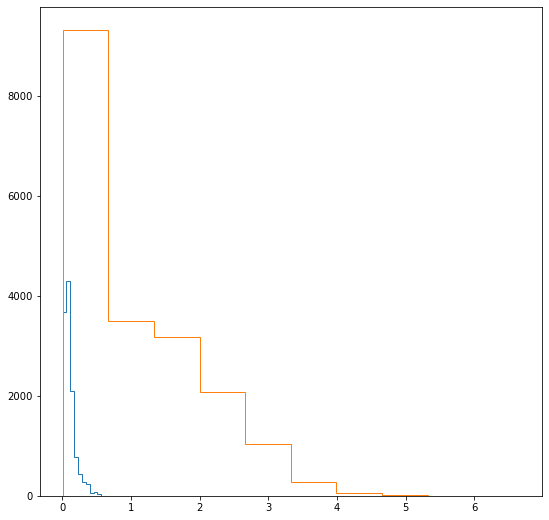

In [76]:
fig = plt.figure(figsize=(9,9))
plt.hist(z[((z>0)&((subclass==b'STARFORMING')|(subclass==b'STARBURST  ')))], histtype="step")
plt.hist(z[((z>0)&((subclass==b'AGN        ')|(subclass==b'BROADLINE  ')))], histtype="step")

(array([6.3492e+04, 6.1850e+03, 3.9320e+03, 2.5120e+03, 1.0910e+03,
        2.8700e+02, 9.6000e+01, 9.5000e+01, 7.0000e+01, 6.3000e+01]),
 array([2.18892993e-08, 7.00987025e-01, 1.40197403e+00, 2.10296103e+00,
        2.80394803e+00, 3.50493504e+00, 4.20592204e+00, 4.90690904e+00,
        5.60789605e+00, 6.30888305e+00, 7.00987005e+00]),
 [<matplotlib.patches.Polygon at 0x824019be0>])

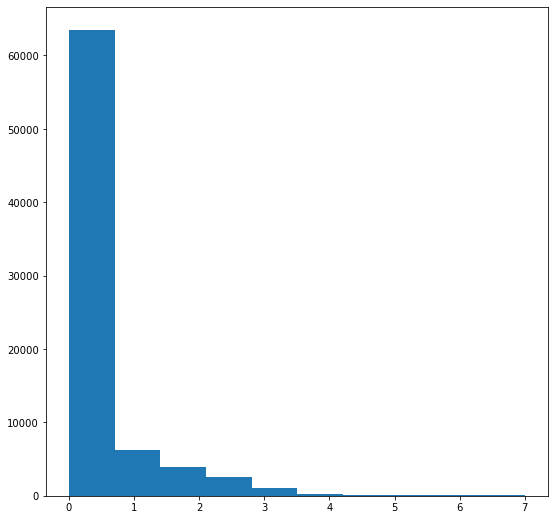

In [77]:
fig = plt.figure(figsize=(9,9))
plt.hist(z[(z>0)], histtype="stepfilled")

---

Now introduce some WISE data - not quite sure exactly what I want to do yet, but the main idea is that: we want a fairly large sample of sources that will lie on the FIR-Radio correlation.  The easiest way to get such sources is just by taking all star-forming+starburst galaxies, but we can only get so far in redshift with that.  There's reason to believe that a sizable chunk of the RQQ population may lie on the FRC as well, so if we carefully select those, we can increase our numbers and hopefully push the redshift boundary a bit farther out.

WISE has four passbands:

    - W1: 3.368 µm
    - W2: 4.618 µm
    - W3: 12.082 µm
    - W4: 22.194 µm
    
Where the first two will likely be effective in selection (e.g., [Stern et al. 2012](https://ui.adsabs.harvard.edu/abs/2012ApJ...753...30S/abstract)), and I'm guessing that W4 may be the most useful in this investigation.  Not as many sources will be detected in that passband, but there should still be a much higher number detected than at ~100 or ~160µm.  My thought is that there must be some work out there turning WISE data into SFRs (effectively just filtering out the AGN contribution to the mid-infrared), so we should at least be able to make a plot of [Measured radio luminosity] vs [FIR luminosity obtained from MIR WISE data] to see if this is something that will be worthwhile expanding.

Note that I'm only using a small subset of the [Kimball & Ivezic catalog](http://www.aoc.nrao.edu/~akimball/radiocat_2.0.shtml), which covers

* 150$^\circ$ < RA < 165$^\circ$
* 40$^\circ$ < Dec < 50$^\circ$,

so don't worry too much if the numbers seem small right now.  It's tricky to predict how many numbers we'll actually get in total though, since the depth of WISE gets worse as you move away from the N/S poles.

Also don't worry too much about the number of radio detections.  If we can get good selection down and find an efficient way to make a tight correlation out of [Measured radio luminosity] vs [FIR luminosity obtained from MIR WISE data], then we should be able to use pretty much all of the deeper radio data from more narrow radio surveys (e.g. COSMOS) to get better redshift coverage.

Something that might be troublesome is evolution (so we wouldn't be able to use the fluxes to derive cosmo parameters).  It looked like $\gamma$ was changing with redshift in some of my earlier notebooks, but I couldn't tell if that was real or just some kind of bias/selection effect.  Many works are also conflicting between evolution or no evolution of the FRC, but that may just be since most haven't gone out to far enough redshift.  We'll see.

In [78]:
(z>0).sum() / len(z)

0.13781177783090287

In [79]:
#We need the redshift to predict cosmo parameters, so restrict to objects with known redshifts
wise = cat[z>0]
print(wise.shape)
wise.head()

(77823, 172)


,cntr_01,dist_x,pang_x,uniq_id_01,ra_01,dec_01,matchflag_first_01,matchflag_nvss_01,distance_01,overlap_01,...,ph_qual,moon_lev,w1nm,w1m,w2nm,w2m,w3nm,w3m,w4nm,w4m
1,28,0.986939,-52.891966,27,0.004296,1.404422,-1,1,7.027,0,...,b'AACC',1100,24,24,21,24,b'1 ',b'13 ',b'0 ',b'13 '
3,39,1.260548,14.101835,38,0.005533,4.691272,-1,1,0.591,0,...,b'ABUU',0,22,22,3,22,b'0 ',b'12 ',b'0 ',b'12 '
5,49,0.224733,144.782409,48,0.006571,-9.494484,-1,1,1.480,0,...,b'AABU',3400,27,27,20,20,b'0 ',b'12 ',b'0 ',b'12 '
10,70,0.510467,70.342458,69,0.008946,-9.526931,-1,0,-99.000,0,...,b'AAUC',3400,26,26,19,19,b'0 ',b'12 ',b'0 ',b'12 '
71,473,0.463069,173.891847,472,0.067083,2.498667,-1,1,3.590,0,...,b'AAUU',0,23,23,8,23,b'0 ',b'13 ',b'0 ',b'13 '


In [80]:
w1snr = wise[["w1snr"]].values.flatten()
w2snr = wise[["w2snr"]].values.flatten()
w3snr = wise[["w3snr"]].values.flatten()
w4snr = wise[["w4snr"]].values.flatten()

#Only take objects with numeric S2N ratios 
S2Nmask = ((~np.isnan(w1snr))&(~np.isnan(w2snr))&((w3snr!=b'    ')&(w3snr!=b'null'))&((w4snr!=b'     ')&(w4snr!=b'null ')))
w1snr = w1snr[S2Nmask].astype(float)
w2snr = w2snr[S2Nmask].astype(float)
w3snr = w3snr[S2Nmask].astype(float)
w4snr = w4snr[S2Nmask].astype(float)

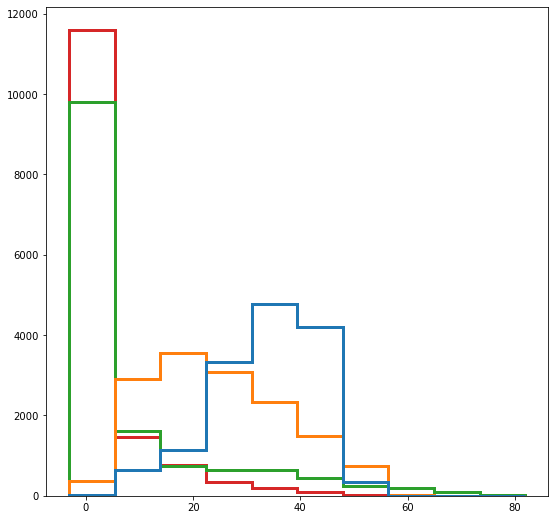

In [81]:
fig = plt.figure(figsize=(9,9))
plt.hist([w1snr, w2snr, w3snr, w4snr], histtype="step", linewidth=3)
plt.show()

Make some color-color plots and see how the SDSS classifications separate.  Now just realizing that the Stern AGN $W1-W2 > 0.8$ criterion focuses mainly on type 2 AGN, so will be interesting to see how these compare (and also even assign classifications to the many objects that lack SDSS classification).

In [82]:
wise = wise[S2Nmask]
(w1snr>10).sum(), (w2snr>10).sum(), (w3snr>10).sum(), (w4snr>10).sum()

(14103, 12912, 3507, 1966)

In [83]:
(w3snr>5).sum()

4805

If we want to use W3 as a SF tracer, those measurements should be reliable.  Start with 10$\sigma$ detections only.

In [34]:
wise = wise[w3snr>10]
len(wise)

3507

In [35]:
W1 = wise[["w1mpro"]].values.flatten().astype(float)
W2 = wise[["w2mpro"]].values.flatten().astype(float)
W3 = wise[["w3mpro"]].values.flatten().astype(float)
W4 = wise[["w4mpro"]].values.flatten().astype(float)

z  = wise[["spec_redshift_01"]].values.flatten()
cat= wise[["spec_class_01"]].values.flatten()
subcat = wise[["spec_subclass_01"]].values.flatten()

In [36]:
cat

array([b'QSO   ', b'GALAXY', b'GALAXY', ..., b'QSO   ', b'GALAXY',
       b'GALAXY'], dtype=object)

In [37]:
gal  = cat==b"GALAXY"
qso  = cat==b"QSO   "
star = cat==b"STAR  "
null = ((~gal)&(~qso)&(~star))

In [38]:
gal.sum(), qso.sum(), star.sum(), null.sum()

(2412, 1080, 15, 0)

In [39]:
def plot_3colors(c1, c2, c3, col, ax, s=35, alpha=1, label="", mask=None):
    #if mask == None:
    #    mask = np.arange(0, len(c1))
    ax.scatter(c2[mask]-c3[mask], c1[mask]-c2[mask], s=s, color=col, alpha=alpha, label=label)
    
def plot_4colors(c1, c2, c3, c4, col, ax, s=35, alpha=1, label="", mask=None):
    #if mask == None:
    #    mask = np.arange(0, len(c1))
    ax.scatter(c3[mask]-c4[mask], c1[mask]-c2[mask], s=s, color=col, alpha=alpha, label=label)

Text(0, 0.5, 'redshift')

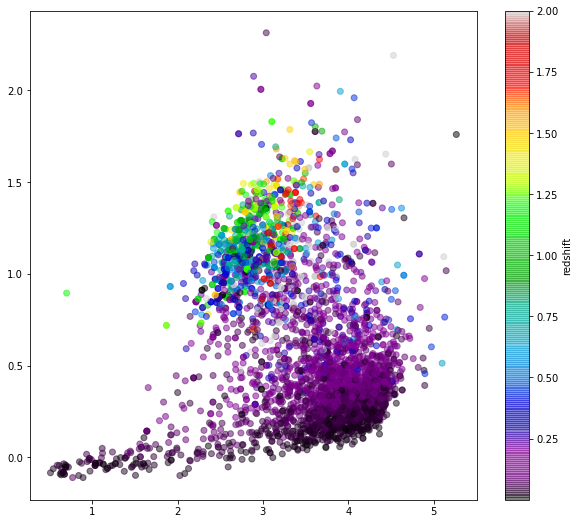

In [40]:
fig = plt.figure(figsize=(10,9))
plt.scatter(W2-W3, W1-W2, alpha=0.5, c=z, cmap="nipy_spectral", vmax=2)
cbar = plt.colorbar()
cbar.ax.set_ylabel('redshift')

Well there's definitely something going on.  Ideally, more of the higher-redshift objects would be away from the Stern et al. $W1-W2 > 0.8$ AGN criterion, but maybe some SFGs are just getting redshifted into that region and some galaxy templates could help.

Looks like the W3 S2N>10 cut mainly removed the branch of objects we don't really want anyway, so that's a positive.

In [41]:
gal.shape

(3507,)

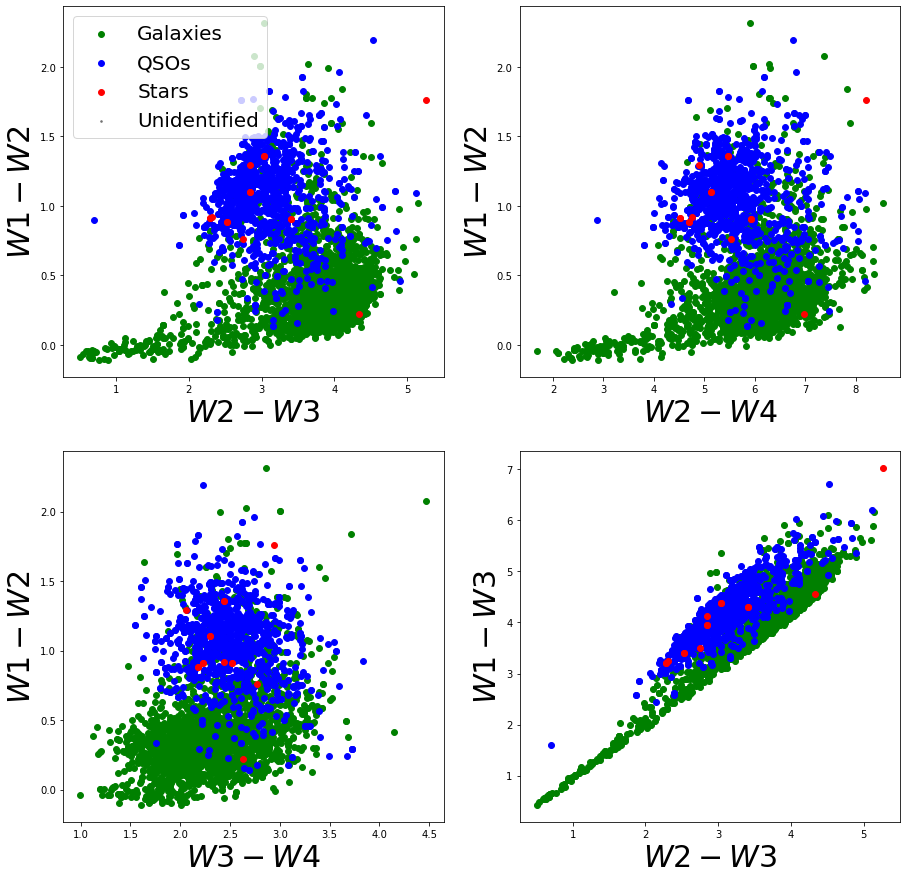

In [42]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(15,15))

plot_3colors(W1, W2, W3, "g", ax1, label="Galaxies", mask=gal)
plot_3colors(W1, W2, W3, "b", ax1, label="QSOs", mask=qso)
plot_3colors(W1, W2, W3, "r", ax1, label="Stars", mask=star)
plot_3colors(W1, W2, W3, "k", ax1, s=3, alpha=0.4, label="Unidentified", mask=null)
ax1.set_ylabel("$W1-W2$", fontsize=30)
ax1.set_xlabel("$W2-W3$", fontsize=30)
ax1.legend(loc="upper left", prop={"size": 20})

plot_3colors(W1, W2, W4, "g", ax2, mask=gal)
plot_3colors(W1, W2, W4, "b", ax2, mask=qso)
plot_3colors(W1, W2, W4, "r", ax2, mask=star)
plot_3colors(W1, W2, W4, "k", ax2, s=3, alpha=0.4, mask=null)
ax2.set_ylabel("$W1-W2$", fontsize=30)
ax2.set_xlabel("$W2-W4$", fontsize=30)

plot_4colors(W1, W2, W3, W4, "g", ax3, mask=gal)
plot_4colors(W1, W2, W3, W4, "b", ax3, mask=qso)
plot_4colors(W1, W2, W3, W4, "r", ax3, mask=star)
plot_4colors(W1, W2, W3, W4, "k", ax3, s=3, alpha=0.4, mask=null)
ax3.set_ylabel("$W1-W2$", fontsize=30)
ax3.set_xlabel("$W3-W4$", fontsize=30)

ax4.scatter(W2[gal]-W3[gal], W1[gal]-W3[gal], color="g")
ax4.scatter(W2[qso]-W3[qso], W1[qso]-W3[qso], color="b")
ax4.scatter(W2[star]-W3[star], W1[star]-W3[star], color="r")
ax4.scatter(W2[null]-W3[null], W1[null]-W3[null], color="k", s=3, alpha=0.2)
ax4.set_ylabel("$W1-W3$", fontsize=30)
ax4.set_xlabel("$W2-W3$", fontsize=30)

plt.show()

Now break this up into the 4 SDSS subclasses:
- AGN
- Broadline
- Starburst
- Starforming
- All without identification I'll refer to as "Unidentified" (as above)

In [43]:
agn  = subcat==b"AGN        "
broad= subcat==b"BROADLINE  "
sfg  = subcat==b"STARFORMING"
sbg  = subcat==b"STARBURST  "
snull= ((~agn)&(~broad)&(~sfg)&(~sbg))

In [44]:
agn.sum(), broad.sum(), sfg.sum(), sbg.sum(), snull.sum()

(543, 780, 1013, 751, 420)

Looks like subclasses aren't that frequent; recall the counts for "classes":

In [45]:
gal.sum(), qso.sum(), star.sum(), null.sum()

(2412, 1080, 15, 0)

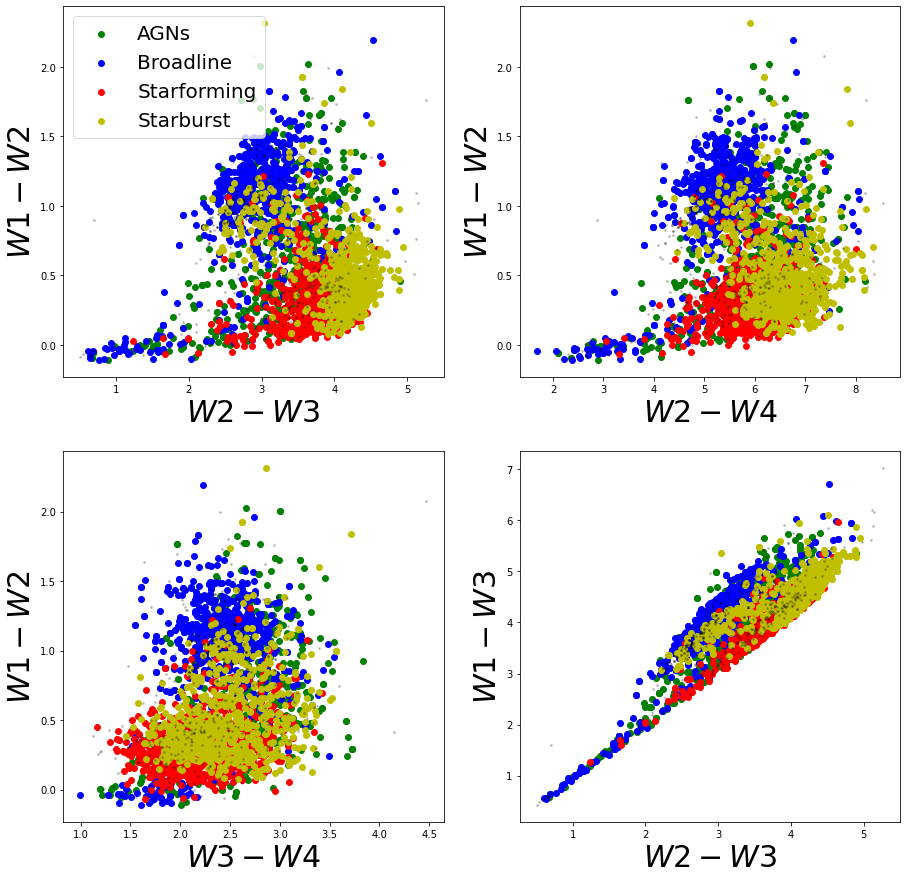

In [46]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(15,15))

plot_3colors(W1, W2, W3, "g", ax1, label="AGNs", mask=agn)
plot_3colors(W1, W2, W3, "b", ax1, label="Broadline", mask=broad)
plot_3colors(W1, W2, W3, "r", ax1, label="Starforming", mask=sfg)
plot_3colors(W1, W2, W3, "y", ax1, label="Starburst", mask=sbg)
plot_3colors(W1, W2, W3, "k", ax1, s=3, alpha=0.2, mask=snull)
ax1.set_ylabel("$W1-W2$", fontsize=30)
ax1.set_xlabel("$W2-W3$", fontsize=30)
ax1.legend(loc="upper left", prop={"size": 20})

plot_3colors(W1, W2, W4, "g", ax2, mask=agn)
plot_3colors(W1, W2, W4, "b", ax2, mask=broad)
plot_3colors(W1, W2, W4, "r", ax2, mask=sfg)
plot_3colors(W1, W2, W4, "y", ax2, mask=sbg)
plot_3colors(W1, W2, W4, "k", ax2, s=3, alpha=0.2, mask=snull)
ax2.set_ylabel("$W1-W2$", fontsize=30)
ax2.set_xlabel("$W2-W4$", fontsize=30)

plot_4colors(W1, W2, W3, W4, "g", ax3, mask=agn)
plot_4colors(W1, W2, W3, W4, "b", ax3, mask=broad)
plot_4colors(W1, W2, W3, W4, "r", ax3, mask=sfg)
plot_4colors(W1, W2, W3, W4, "y", ax3, mask=sbg)
plot_4colors(W1, W2, W3, W4, "k", ax3, s=3, alpha=0.2, mask=snull)
ax3.set_ylabel("$W1-W2$", fontsize=30)
ax3.set_xlabel("$W3-W4$", fontsize=30)

ax4.scatter(W2[agn]-W3[agn], W1[agn]-W3[agn], color="g")
ax4.scatter(W2[broad]-W3[broad], W1[broad]-W3[broad], color="b")
ax4.scatter(W2[sfg]-W3[sfg], W1[sfg]-W3[sfg], color="r")
ax4.scatter(W2[sbg]-W3[sbg], W1[sbg]-W3[sbg], color="y")
ax4.scatter(W2[snull]-W3[snull], W1[snull]-W3[snull], color="k", s=3, alpha=0.2)
ax4.set_ylabel("$W1-W3$", fontsize=30)
ax4.set_xlabel("$W2-W3$", fontsize=30)

plt.show()

Reminder that we basically want to define a region of color-color(-color?) space that does a good job of identifying objects that follow the FIR-radio correlation.  Presumably areas occupied by known SFGs are good places to start.

Now is probably a good place to step back and ask how each of these classes/subclasses follow the FRC -- both with their "raw" WISE measurements, and also after applying some correction to them from the literature.

Bokeh plots will be useful here.

---

Create a plot o the FIR-Radio correlation for these sources.  Then I'll be able to "lasso" areas of color space and see how they lie on the correlation.  [Cluver et al. (2017)](https://ui.adsabs.harvard.edu/abs/2017ApJ...850...68C/abstract) suggest that the W3 fluxes can be used as an accurate star formation tracer:

$$ \log{L_\mathrm{TIR}}(L_\odot)(M_\odot\mathrm{yr}^{-1}) = (0.889 \pm 0.018)\log{L_\mathrm{12\mu{m}}}(L_{\odot}) + (2.21 \pm 0.15) $$

Although I still suspect that we're going to need some kind of nonlinear relation (maybe a function of redshift?) to get something that will follow the "Far"-Infrared--Radio Correlation.

To convert [WISE Vega magnitudes to flux](https://wise2.ipac.caltech.edu/docs/release/allsky/expsup/sec4_4h.html#conv2flux):

$$ F_\nu \mathrm{[Jy]} = F_{\nu_0} \times 10^{(-m_\mathrm{Vega} / 2.5)} $$

Where $F_{\nu_0}$ is specific to each WISE bandpass:

- W1: 309.540 Jy
- W2: 171.787 Jy
- W3: 31.674 Jy
- W4: 8.363 Jy

Let's keep things somewhat simple for now and ignore errors.

In [47]:
#Useful functions for this part
def luminosity(nu1, nu2, S, alpha, z):
    #calculate luminosity at nu1 based on flux at nu2
    #flux in µJy
    #luminosity in log, W/Hz
    DL = 3.086e24*cosmo.luminosity_distance(z).value
    L = ((4*np.pi*DL**2*(S*1e-23*1e-6)) / ((1+z)**(1+alpha))) * (nu1/nu2)**alpha * 1e-7
    return np.log10(L)

def micron_to_ghz(wavelength):
    #convert wavelength in microns to GHz - easier to input to luminosity() function
    return (3.e8 / (wavelength*1e-6)) * 1e-9

In [48]:
F3  = ( 31.674 * 10**(-W3/2.5) ) * 1.e3 #convert to mJy
F4  = ( 8.363 * 10**(-W4/2.5) ) * 1.e3

In [49]:
F3

array([ 1.75510423,  4.34013174,  2.1257046 , ..., 10.25894998,
       45.53055166, 45.53055166])

In [50]:
#Need to use a mix of FIRST/NVSS flux densities
first = wise[["first_fpeak_01"]].values.flatten()
nvss  = wise[["nvss_peak_01"]].values.flatten()
(first==-99).sum(), (nvss==-99).sum(), ((first==-99)&(nvss==-99)).sum()

(28, 1467, 0)

Good, every object is detected in one of FIRST or NVSS.  Use FIRST data where it's available, and NVSS where it's not.

In [51]:
Frad = first
Frad[first==-99] = nvss[first==-99]
(Frad==-99).any()

False

Might think of redshift estimation of unidentified sources as an enhanced goal.  I think I remember other papers already doing that work?  We're obviously going to need to know the redshift of each object to follow the Lusso/Risaliti method.

In [52]:
#Compute luminosities in W/Hz - function assumes µJy input
L12 = luminosity(micron_to_ghz(12.), micron_to_ghz(12.), F3, 0.0, z)
L23 = luminosity(micron_to_ghz(23.), micron_to_ghz(23.), F4, 0.0, z)
Lrad= luminosity(1.4, 1.4, Frad, 0.0, z)

Finally, make some plots of IR vs Radio emission.  Simple at first, but then color by SDSS class/subclass (same as color plots above).

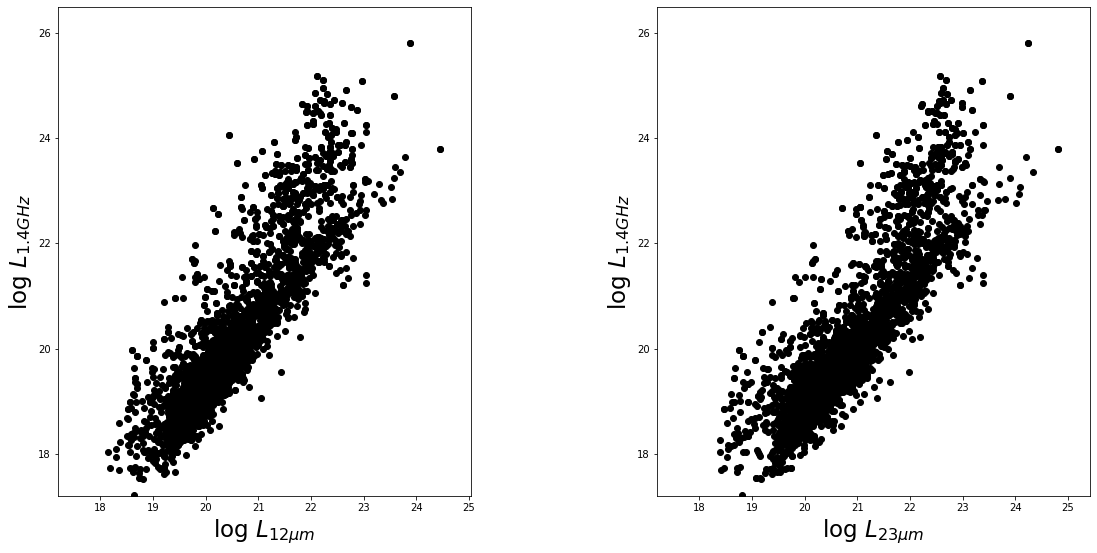

In [53]:
fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(20,9))

ax1.scatter(L12, Lrad, color="k")
ax1.set_xlabel("log $L_{12\mu{m}}$", fontsize=23)
ax1.set_ylabel("log $L_{1.4GHz}$", fontsize=23)
ax1.set_xlim(17.2, ax1.get_xlim()[1])
ax1.set_ylim(17.2, ax1.get_ylim()[1])
ax1.set_aspect("equal")

ax2.scatter(L23, Lrad, color="k")
ax2.set_xlabel("log $L_{23\mu{m}}$", fontsize=23)
ax2.set_ylabel("log $L_{1.4GHz}$", fontsize=23)
ax2.set_xlim(17.2, ax2.get_xlim()[1])
ax2.set_ylim(17.2, ax2.get_ylim()[1])
ax2.set_aspect("equal")

Split into QSO/Galaxy classes

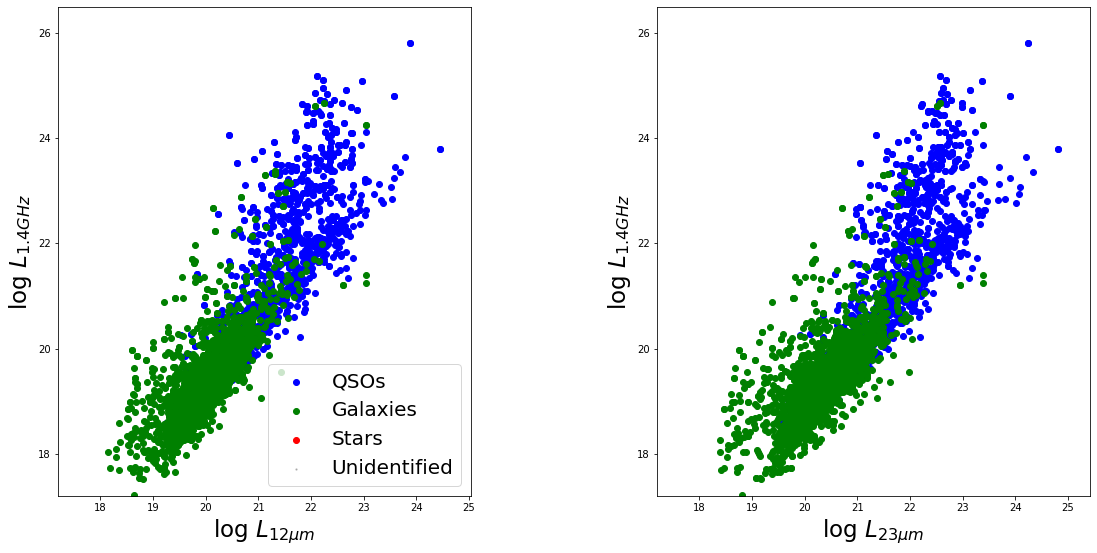

In [54]:
fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(20,9))

ax1.scatter(L12[qso], Lrad[qso], color="b", label="QSOs")
ax1.scatter(L12[gal], Lrad[gal], color="g", label="Galaxies")
ax1.scatter(L12[star], Lrad[star], color="r", label="Stars")
ax1.scatter(L12[null], Lrad[null], color="k", alpha=0.2, s=2, label="Unidentified")
ax1.set_xlabel("log $L_{12\mu{m}}$", fontsize=23)
ax1.set_ylabel("log $L_{1.4GHz}$", fontsize=23)
ax1.set_xlim(17.2, ax1.get_xlim()[1])
ax1.set_ylim(17.2, ax1.get_ylim()[1])
ax1.set_aspect("equal")
ax1.legend(loc="best", prop={"size": 20})

ax2.scatter(L23[qso], Lrad[qso], color="b", label="QSOs")
ax2.scatter(L23[gal], Lrad[gal], color="g", label="Galaxies")
ax2.scatter(L23[star], Lrad[star], color="r", label="Stars")
ax2.scatter(L23[null], Lrad[null], color="k", alpha=0.2, s=2, label="Unidentified")
ax2.set_xlabel("log $L_{23\mu{m}}$", fontsize=23)
ax2.set_ylabel("log $L_{1.4GHz}$", fontsize=23)
ax2.set_xlim(17.2, ax2.get_xlim()[1])
ax2.set_ylim(17.2, ax2.get_ylim()[1])
ax2.set_aspect("equal")

[See ``kimball_catalog_small.ipynb`` for this comment to make sense]

Interesting they separate like that, because there's definitely a gap in to W3 relation (in the galaxies and not the QSOs?).  In a perfect world, those would be two separates sequences and we'd be able to choose which is a better calibration option.  See what the subclasses look like.

In [55]:
agn.sum(), broad.sum(), sfg.sum(), sbg.sum(), snull.sum()

(543, 780, 1013, 751, 420)

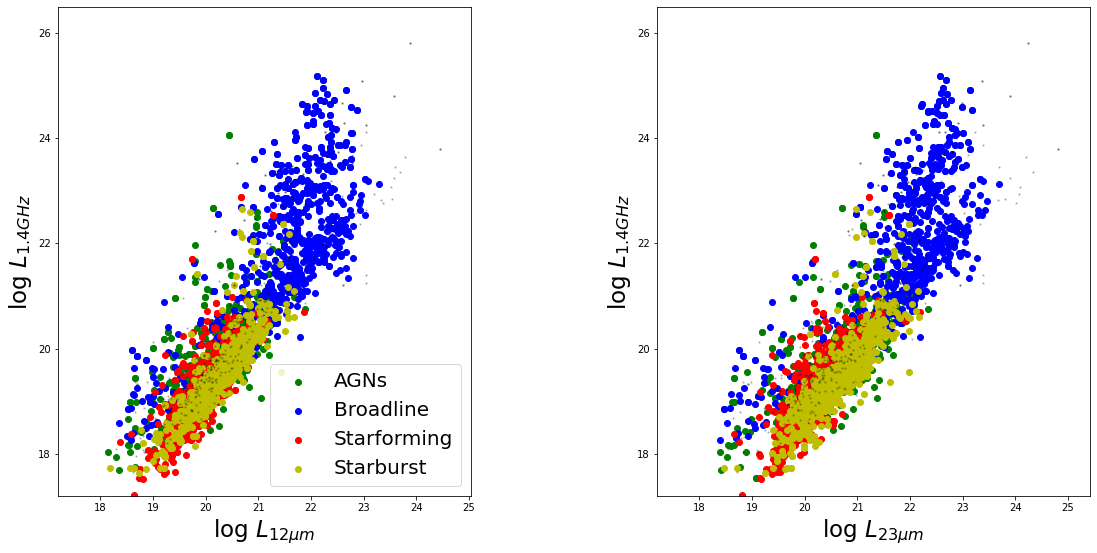

In [56]:
fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(20,9))

ax1.scatter(L12[agn], Lrad[agn], color="g", label="AGNs")
ax1.scatter(L12[broad], Lrad[broad], color="b", label="Broadline")
ax1.scatter(L12[sfg], Lrad[sfg], color="r", label="Starforming")
ax1.scatter(L12[sbg], Lrad[sbg], color="y", label="Starburst")
ax1.scatter(L12[snull], Lrad[snull], color="k", alpha=0.2, s=2)
ax1.set_xlabel("log $L_{12\mu{m}}$", fontsize=23)
ax1.set_ylabel("log $L_{1.4GHz}$", fontsize=23)
ax1.set_xlim(17.2, ax1.get_xlim()[1])
ax1.set_ylim(17.2, ax1.get_ylim()[1])
ax1.set_aspect("equal")
ax1.legend(loc="best", prop={"size": 20})

ax2.scatter(L23[agn], Lrad[agn], color="g", label="AGNs")
ax2.scatter(L23[broad], Lrad[broad], color="b", label="Broadline")
ax2.scatter(L23[sfg], Lrad[sfg], color="r", label="Starforming")
ax2.scatter(L23[sbg], Lrad[sbg], color="y", label="Starburst")
ax2.scatter(L23[snull], Lrad[snull], color="k", alpha=0.2, s=2)
ax2.set_xlabel("log $L_{23\mu{m}}$", fontsize=23)
ax2.set_ylabel("log $L_{1.4GHz}$", fontsize=23)
ax2.set_xlim(17.2, ax2.get_xlim()[1])
ax2.set_ylim(17.2, ax2.get_ylim()[1])
ax2.set_aspect("equal")

OK, better than I was expecting at least: a group of sources appear to follow a somewhat tight correlation.  The downside though is that those sources aren't particularly luminous in the radio.  See what we can do.

Format Bokeh plots.

In [57]:
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.layouts import gridplot, row

In [58]:
len(wise)

3507

In [59]:
#Lists of props
colors = []
for i in range(len(wise)):
    if agn[i]: colors.append("green")
    elif broad[i]: colors.append("blue")
    elif sfg[i]: colors.append("red")
    elif sbg[i]: colors.append("orange")
    else: colors.append("black")

sizes = []
alphas= []
for i in range(len(wise)):
    if ~snull[i]: #if there's an SDSS classification, give these props
        sizes.append(5)
        alphas.append(1)
    else:
        sizes.append(1)
        alphas.append(0.2)

#Create the source for bokeh plots - track colors
source = ColumnDataSource(data=dict(  #create source for detections
    LR = Lrad,
    LIR12 = L12,
    LIR23 = L23,
    W1W2 = W1-W2,
    W2W3 = W2-W3,
    W3W4 = W3-W4,
    W1W3 = W1-W3,
    W2W4 = W2-W4,
    sz = sizes,
    fill = alphas,
    col = colors
))

In [60]:
# create a new plot with the toolbar below
p1 = figure(title=None, toolbar_location="below", tools='lasso_select,pan,box_zoom,wheel_zoom,save,reset,help')
p1.circle("LIR12", "LR", color="col", size="sz", fill_alpha="fill",
         source=source)
p1.xaxis.axis_label = 'L_12micron'
p1.yaxis.axis_label = 'L_1.4GHz'

p2 = figure(title=None, toolbar_location="below", tools='lasso_select,pan,box_zoom,wheel_zoom,save,reset,help')
p2.circle("LIR23", "LR", color="col", size="sz", fill_alpha="fill",
         source=source)
p2.xaxis.axis_label = 'L_23micron'
p2.yaxis.axis_label = 'L_1.4GHz'

p3 = figure(title=None, toolbar_location="below", tools='lasso_select,pan,box_zoom,wheel_zoom,save,reset,help')
p3.circle("W2W3", "W1W2", color="col", size="sz", fill_alpha="fill",
         source=source)
p3.xaxis.axis_label = 'W2 - W3'
p3.yaxis.axis_label = 'W1 - W2'

p4 = figure(title=None, toolbar_location="below", tools='lasso_select,pan,box_zoom,wheel_zoom,save,reset,help')
p4.circle("W2W4", "W1W2", color="col", size="sz", fill_alpha="fill",
         source=source)
p4.xaxis.axis_label = 'W2 - W4'
p4.yaxis.axis_label = 'W1 - W2'

p5 = figure(title=None, toolbar_location="below", tools='lasso_select,pan,box_zoom,wheel_zoom,save,reset,help')
p5.circle("W3W4", "W1W2", color="col", size="sz", fill_alpha="fill",
         source=source)
p5.xaxis.axis_label = 'W3 - W4'
p5.yaxis.axis_label = 'W1 - W2'

p6 = figure(title=None, toolbar_location="below", tools='lasso_select,pan,box_zoom,wheel_zoom,save,reset,help')
p6.circle("W2W3", "W1W3", color="col", size="sz", fill_alpha="fill",
         source=source)
p6.xaxis.axis_label = 'W2 - W3'
p6.yaxis.axis_label = 'W1 - W3'

# make a grid
grid = gridplot([[p1, p2, p3], [p4, p5, p6]], plot_width=600, plot_height=500)

show(grid)

Should cut the radio-loud quasars?  That won't fix everything, but might explain why some QSOs that appear to have the same W1W2W3 colors as the SFGs, but are far off the MIR-Radio correlation.

---

Should get the COSMOS/ECDFS data involved.  Have some *far*-infrared data for those sources, but should probably use WISE colors to remain consistent.  (Or maybe try to calibrate the WISE colors to the FIR?)

In [63]:
ecdfs = pd.read_csv("Bonzini_All_Radio_FIR_GOODS-ECDFS_noidentical.csv")
print(ecdfs.shape)
ecdfs.head()

(480, 59)


,Unnamed: 0,fld,Name,MIPS24,RAJ2000_1,DEJ2000_1,F24,e_F24,FP100,e_FP100,...,logLX,logq24o,log_S3_S1_,log_S4_S2_,alphar,BMAG,QF,f_logq24o,Simbad_2,Separation
0,0,b'GOODSS',b'GOODS_J033242.62-273816.3',1,53.177582,-27.637856,177.3,7.6,NaN,NaN,...,44.60,-2.86,0.81,0.74,NaN,NaN,3,0,b'Simbad',0.620430
1,1,b'GOODSS',b'GOODS_J033242.59-273825.9',6,53.177456,-27.640530,1786.5,20.3,46.79,0.79,...,41.09,0.93,0.71,3.70,NaN,-20.67,3,0,b'Simbad',0.179046
2,2,b'GOODSS',b'GOODS_J033231.16-273917.9',55,53.129852,-27.654976,222.8,8.5,3.44,0.45,...,43.56,0.53,0.70,0.86,NaN,NaN,3,0,b'Simbad',0.346486
3,3,b'GOODSS',b'GOODS_J033225.97-273931.1',65,53.108219,-27.658644,90.3,7.9,NaN,NaN,...,42.91,0.43,NaN,NaN,NaN,NaN,2,0,b'Simbad',0.548641
4,4,b'GOODSS',b'GOODS_J033233.55-273929.0',68,53.139786,-27.658045,313.1,9.9,8.87,0.89,...,42.77,0.79,0.67,0.91,NaN,-22.24,1,0,b'Simbad',0.267408


In [64]:
ecdfs.columns

Index(['Unnamed: 0', 'fld', 'Name', 'MIPS24', 'RAJ2000_1', 'DEJ2000_1', 'F24',
       'e_F24', 'FP100', 'e_FP100', 'FP160', 'e_FP160', 'Clean', 'fa', 'FP70',
       'e_FP70', 'all', 'recno_1', 'RAJ2000_2', 'DEJ2000_2', 'SNR', 'Sp',
       'e_Sp', 'Si', 'e_Si', 'PAmos', 'Best', 'RMS', 'Ext_', 'FC', 'K08', 'Sk',
       'e_Sk', 'l_Size', 'Size', 'Rem', 'Fig', 'DR1', 'B12', 'Simbad_1',
       'recno_2', 'Separation_1', 'RID', 'RAJ2000', 'DEJ2000', 'Class', 'z',
       'logPr', 'l_logLX', 'logLX', 'logq24o', 'log_S3_S1_', 'log_S4_S2_',
       'alphar', 'BMAG', 'QF', 'f_logq24o', 'Simbad_2', 'Separation'],
      dtype='object')

Match this to WISE.

---

Now the COSMOS data.

In [65]:
dat = Table.read("Smolic2017_RadioFIR_all.fits", format="fits")
cosmos = dat.to_pandas()
print(cosmos.shape)
cosmos.head()

(6764, 59)


,ID,---,COSMOSVLA3,RAdeg,e_RAdeg,DEdeg,e_DEdeg,Flux,e_Flux,rms,...,e_FP100,FP160,e_FP160,Clean,fa,FP70,e_FP70,all,recno,Separation
0,5073,b'COSMOSVLA3',b'J095738.95+020253.8',149.412323,0.064,2.048287,0.064,38.799999,5.0,4.59,...,2.16,40.97,3.70,0,0,NaN,NaN,b'all',17307,0.252547
1,5006,b'COSMOSVLA3',b'J095739.00+022507.3',149.412521,0.064,2.418709,0.064,39.900002,5.2,4.75,...,1.66,29.33,5.21,1,0,NaN,NaN,b'all',39410,0.093289
2,3073,b'COSMOSVLA3',b'J095739.62+020237.5',149.415100,0.045,2.043777,0.045,56.200001,5.6,4.65,...,1.91,26.06,3.46,11,0,NaN,NaN,b'all',37875,0.247267
3,7033,b'COSMOSVLA3',b'J095739.80+024144.3',149.415833,0.081,2.695665,0.081,29.799999,4.8,4.49,...,NaN,NaN,NaN,2,0,NaN,NaN,b'all',47874,0.272821
4,10198,b'COSMOSVLA3',b'J095739.94+021441.8',149.416428,0.100,2.244969,0.100,22.799999,4.6,4.39,...,NaN,NaN,NaN,1,0,NaN,NaN,b'all',8240,0.511000


In [66]:
cosmos.columns

Index(['ID', '---', 'COSMOSVLA3', 'RAdeg', 'e_RAdeg', 'DEdeg', 'e_DEdeg',
       'Flux', 'e_Flux', 'rms', 'SNR', 'Npix', 'Res', 'Multi_1', 'id_vla',
       'ra', 'dec', 'multi_2', 'cat_cpt', 'id_cpt', 'ra_cpt_j2000',
       'dec_cpt_j2000', 'sep_vla_cpt', 'p_false', 'z_best', 'flux_int_3ghz',
       'lradio_10cm', 'lradio_21cm', 'l_tir_sf', 'sfr_kenn98', 'xray_agn',
       'mir_agn', 'sed_agn', 'quiescent_mlagn', 'sfg', 'clean_sfg', 'hlagn',
       'mlagn', 'radio_excess', 'flag_cosmos2015', 'Separation_1', 'fld',
       'Name', 'MIPS24', 'RAJ2000', 'DEJ2000', 'F24', 'e_F24', 'FP100',
       'e_FP100', 'FP160', 'e_FP160', 'Clean', 'fa', 'FP70', 'e_FP70', 'all',
       'recno', 'Separation'],
      dtype='object')

Match this to WISE also.